In [4]:
import os
import pandas as pd
import numpy as np
from datasketch import MinHash, MinHashLSHEnsemble
from typing import List, Tuple

In [1]:
from analyzer.external_attribute_analyzer import ExternalAttributeAnalyzer
from analyzer.result_printer import ResultPrinter


In [2]:
import pandas as pd
from collections import defaultdict

def evaluate_predictions(predictions_list, ground_truth_csv):
    # Load ground truth data
    gt_df = pd.read_csv(ground_truth_csv)
    
    # Create mappings from version_name to joined_tables and join_type
    gt_mapping = {}
    for _, row in gt_df.iterrows():
        tables = [t.strip() for t in row['joined_tables'].split('+')]
        gt_mapping[row['version_name']] = {
            'tables': tables,
            'join_type': row['join_type']
        }
    
    # Initialize results storage
    results = []
    
    # Process each prediction
    for predictions in predictions_list:
        version_name = predictions['new_table']
        if version_name not in gt_mapping:
            continue
            
        correct_data = gt_mapping[version_name]
        correct_tables = correct_data['tables']
        correct_join_type = correct_data['join_type']
        
        # Initialize counters
        table_correct = 0
        join_type_correct = 0
        total_columns = 0
        
        # Check each predicted column
        for column, data in predictions['results'].items():
            matches = data['matches']
            if not matches:
                continue
                
            # Get best match (highest jaccard_sim)
            best_match = max(matches, key=lambda x: x['jaccard_sim'])
            predicted_table = best_match['table']
            predicted_join_type = best_match['join_type'][0]  # extract join type from tuple
            
            # Check table prediction (base names without suffixes)
            base_predicted = predicted_table.split('_')[0]
            base_correct = [t.split('_')[0] for t in correct_tables]
            
            if base_predicted in base_correct:
                table_correct += 1
            
            # Check join type prediction
            if predicted_join_type == correct_join_type:
                join_type_correct += 1
                
            total_columns += 1
        
        # Calculate precisions for this version
        table_precision = table_correct / total_columns if total_columns else 0
        join_type_precision = join_type_correct / total_columns if total_columns else 0
        
        results.append({
            'version_name': version_name,
            'total_columns': total_columns,
            'table_correct': table_correct,
            'table_precision': table_precision,
            'join_type_correct': join_type_correct,
            'join_type_precision': join_type_precision
        })
    
    # Convert results to DataFrame and merge with original ground truth
    results_df = pd.DataFrame(results)
    final_df = gt_df.merge(results_df, on='version_name', how='left')
    
    # Calculate mean precisions
    mean_table_precision = results_df['table_precision'].mean()
    mean_join_type_precision = results_df['join_type_precision'].mean()
    
    print(f"Mean table prediction precision: {mean_table_precision:.2%}")
    print(f"Mean join type prediction precision: {mean_join_type_precision:.2%}")
    
    return final_df


In [7]:
# Initialize analyzer and printer
analyzer = ExternalAttributeAnalyzer(num_perm=128)
printer = ResultPrinter()

    # Define your configurations
configurations=[]
for filename in os.listdir("D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/Versions"):
    configurations.append(            {
            "base_file": "D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/IMDB_Base.csv",
            "new_file": "D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/Versions/"+filename,
            "candidate_dir": "sinteticDB/IMDB/externalTables"
        })
# Define your configurations
#configurations = [
#    {
#        "base_file": "D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/IMDB_Base.csv",
#        "new_file": "D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/Versions/imdb_comprehensive.csv",
#        "candidate_dir": "sinteticDB/IMDB/externalTables"
#    },
    # Add more configurations as needed
#]

# Process each configuration
res=[]
for config in configurations:
    print(f"\n{'='*50}")
    print(f"Analyzing: {config['new_file']}")
    print(f"{'='*50}\n")
    
    # Perform analysis (no printing here)
    results = analyzer.analyze_new_attributes(
        base_file=config['base_file'],
        new_file=config['new_file'],
        candidate_dir=config['candidate_dir']
    )
    res.append(results)
    
    # Now print the results when we want to
    printer.print_analysis_results(results)


Analyzing: D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/Versions/imdb_comprehensive.csv

🆕 New attributes detected: Price, Profitability_Ratio, Production_Budget, User_Rating, Subscription_Required, Primary_Production_Company, Release_Date, Release_Season, Available_On, Box_Office_Gross

🔍 Analyzing new attribute: `Price`

Top Candidate Matches:
 → streaming.Price | Jaccard: 1.0000 | Join: left

✅ Best match for `Price`: streaming.Price → obtained through left join on original_table.Series_Title = streaming.Series_Title (Jaccard sim: 1.0000)

🔍 Analyzing new attribute: `Profitability_Ratio`

Top Candidate Matches:
 → financials.Profitability_Ratio | Jaccard: 1.0000 | Join: left

✅ Best match for `Profitability_Ratio`: financials.Profitability_Ratio → obtained through left join on original_table.Series_Title = financials.Series_Title (Jaccard sim: 1.0000)

🔍 Analyzing new attribute: `Production_Budget`

Top Candidate Matches:
 → financials.Production_Budget | Jaccard: 1.0000 | Join: 

In [8]:
results_with_evaluation=evaluate_predictions(res,"D:/uni/AdvancedTopics/project2/sinteticDB/IMDB/ground_truth_versions.csv")

Mean table prediction precision: 80.94%
Mean join type prediction precision: 61.92%


In [9]:
results_with_evaluation.to_csv("results_precision.csv",index=False)

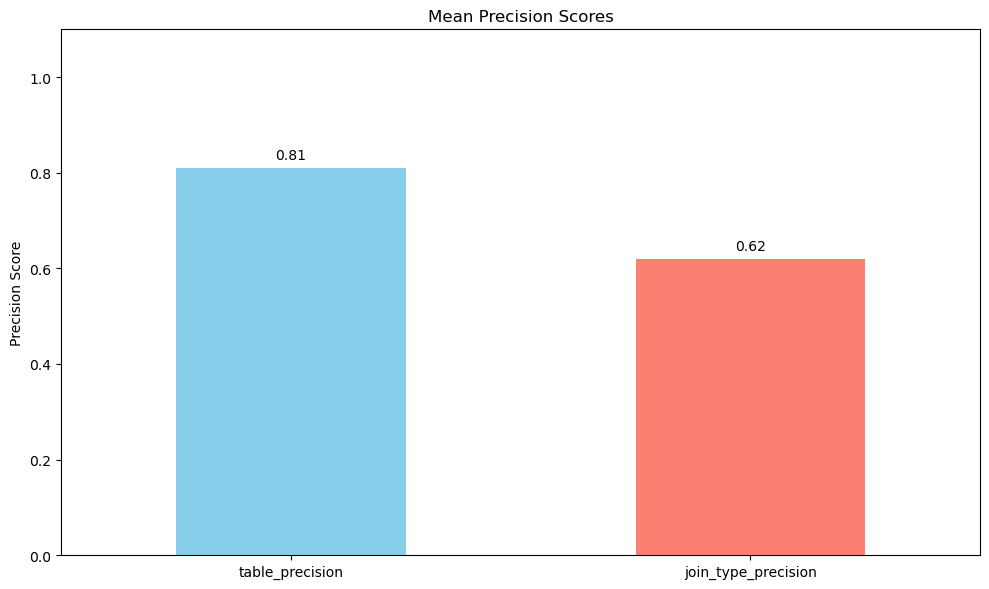

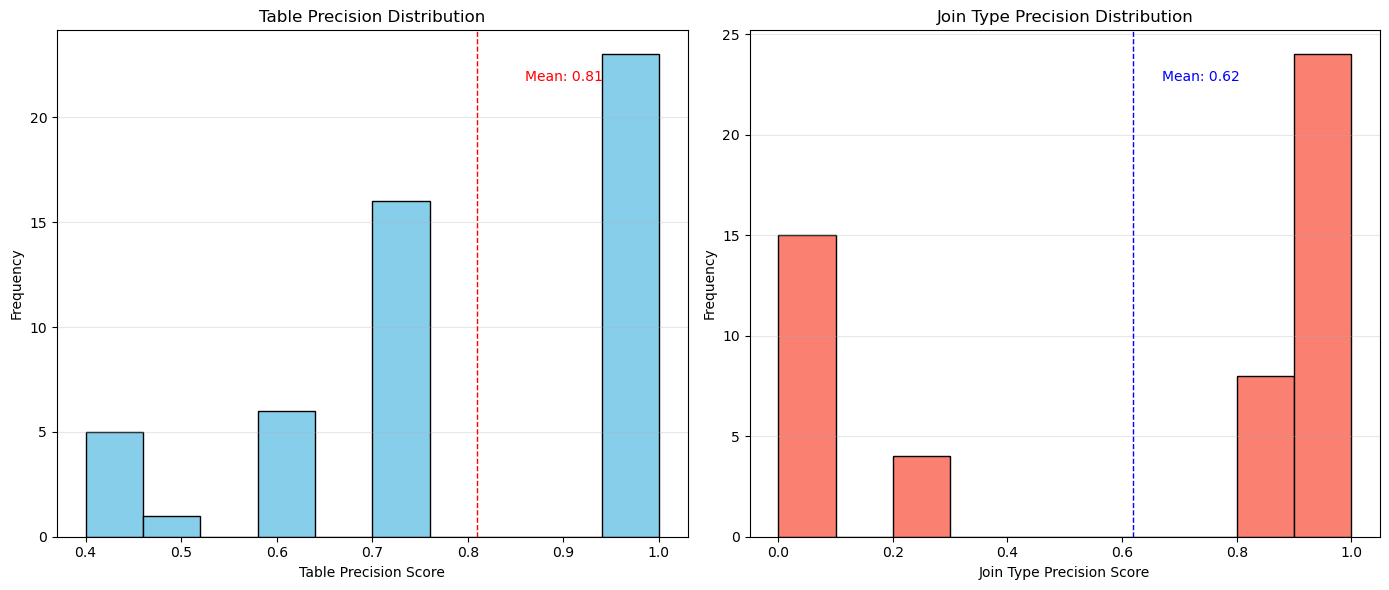

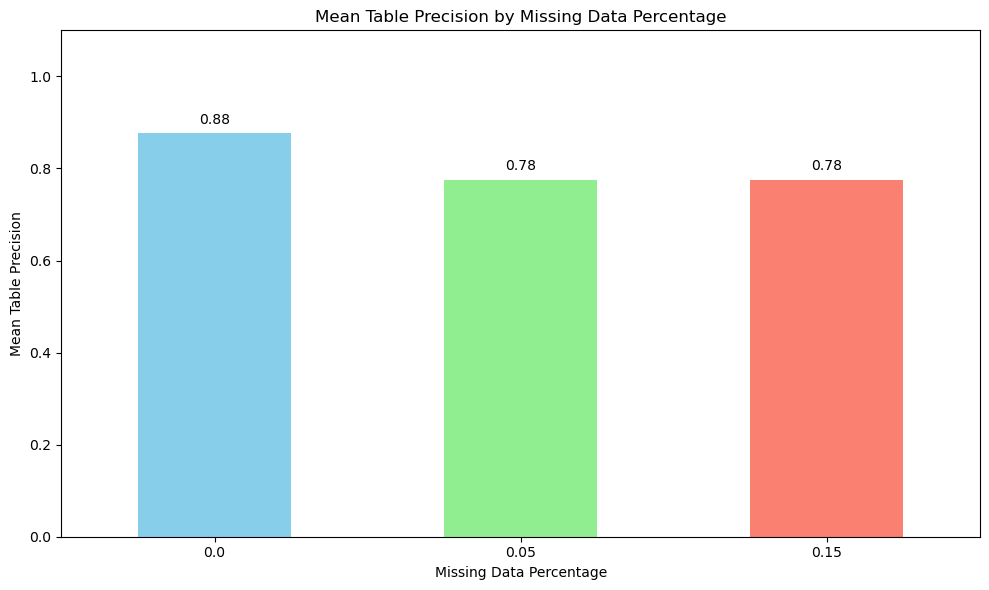

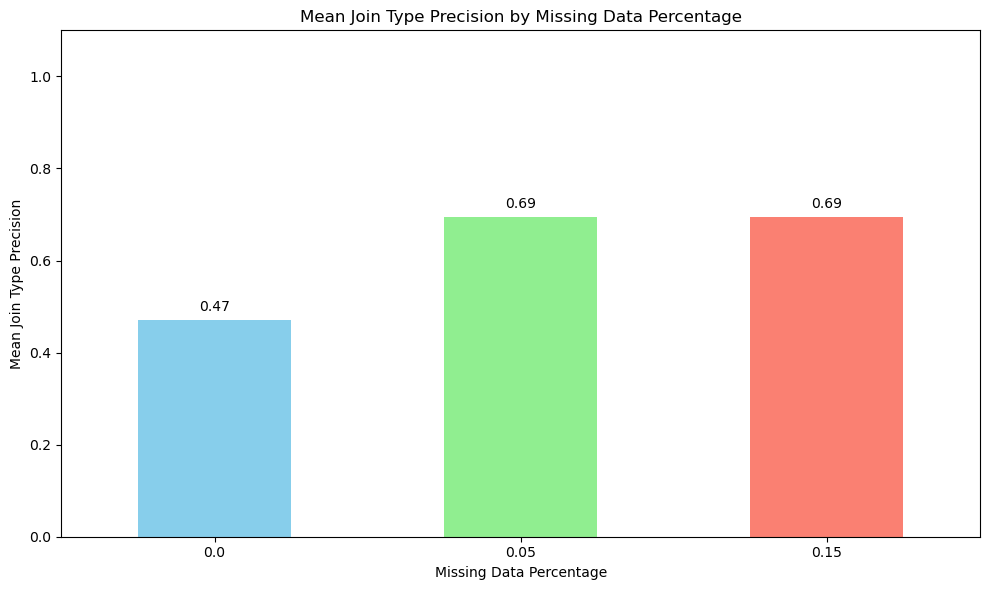

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv(r"D:\uni\AdvancedTopics\project2\sinteticDB\IMDB\results_precision.csv")

# Clean the data - some rows have missing values for precision metrics
df = df.dropna(subset=['table_precision', 'join_type_precision'])

# Visualization 1: Mean table precision and join type precision
plt.figure(figsize=(10, 6))
means = df[['table_precision', 'join_type_precision']].mean()
means.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Mean Precision Scores')
plt.ylabel('Precision Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
for i, v in enumerate(means):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Visualization 2: Table precision and join type precision distribution
# Set up the figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Table Precision Distribution
plt.subplot(1, 2, 1)
plt.hist(df['table_precision'], bins=10, color='skyblue', edgecolor='black')
plt.title('Table Precision Distribution')
plt.xlabel('Table Precision Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

# Add mean line and annotation
mean_table = df['table_precision'].mean()
plt.axvline(mean_table, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_table+0.05, plt.ylim()[1]*0.9, f'Mean: {mean_table:.2f}', color='red')

# Subplot 2: Join Type Precision Distribution
plt.subplot(1, 2, 2)
plt.hist(df['join_type_precision'], bins=10, color='salmon', edgecolor='black')
plt.title('Join Type Precision Distribution')
plt.xlabel('Join Type Precision Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)

# Add mean line and annotation
mean_join = df['join_type_precision'].mean()
plt.axvline(mean_join, color='blue', linestyle='dashed', linewidth=1)
plt.text(mean_join+0.05, plt.ylim()[1]*0.9, f'Mean: {mean_join:.2f}', color='blue')

plt.tight_layout()
plt.show()

# Visualization 3: Mean table precision by missing data percentage
plt.figure(figsize=(10, 6))
missing_groups = df.groupby('missing_data_percentage')['table_precision'].mean()
missing_groups.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Mean Table Precision by Missing Data Percentage')
plt.ylabel('Mean Table Precision')
plt.xlabel('Missing Data Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
for i, v in enumerate(missing_groups):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Visualization 4: Mean join type precision by missing data percentage
plt.figure(figsize=(10, 6))
missing_groups = df.groupby('missing_data_percentage')['join_type_precision'].mean()
missing_groups.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Mean Join Type Precision by Missing Data Percentage')
plt.ylabel('Mean Join Type Precision')
plt.xlabel('Missing Data Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
for i, v in enumerate(missing_groups):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.tight_layout()
plt.show()